# Product Classification

In [1]:
from keras.applications import ResNet50

Using TensorFlow backend.


In [2]:
import cv2
import tensorflow
import glob
import numpy as np
import scipy
import os
import fnmatch
import matplotlib.pyplot as plt
%matplotlib inline
from keras import models,regularizers
from keras import layers
from keras import optimizers
from keras.layers import Dense,Flatten,Dropout,Input
from keras.models import Model
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.metrics import confusion_matrix,classification_report
import itertools

In [179]:
input_shape = Input(shape=(224,224,3))

In [180]:
def resnet():
    
    resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=input_shape)
    for layer in resnet.layers[:20]:
        layer.trainable = False
    return resnet.output

In [181]:
def dense(block1):
    flat = Flatten()(block1)
    dense1 = Dense(512, activation='relu')(flat)
    drop1 = Dropout(0.3)(dense1)
    dense1 = Dense(512, activation='relu')(drop1)
    drop2 = Dropout(0.3)(dense1)
    dense2 = Dense(4,activation='softmax')(drop2)
    return dense2

In [182]:
block1 = resnet()
combined_model = Model(inputs=input_shape,outputs=dense(block1))

In [183]:
combined_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D) (None, 230, 230, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_2[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [148]:
path = 'Data/Training/'

configfiles = [os.path.join(subdir,f)
for subdir, dirs, files in os.walk(path)
    for f in fnmatch.filter(files, '*')]

### Data Augmentation : Flip each image left right!

The below code will keep the original images. Hence, the total images will be doubled.

In [ ]:
for i in configfiles:
    img = cv2.imread(i)
    im = np.fliplr(img)
    cv2.imwrite(i.split('.')[0] + 'fliplr.JPG',im)

In [149]:
imgs = []
label = []

In [150]:
for i in configfiles:
    img = cv2.imread(i)
    if img is not None:
        img = cv2.resize(img,(224,224))
        img = img[:,:,::-1]
        name = i.split('/')
        label.append(name[2])
        imgs.append(img)

In [151]:
train_imgs = np.array(imgs)

In [152]:
train_imgs.shape

(937, 224, 224, 3)

In [153]:
labels = np.array(label)

In [154]:
conversion = {'ThumbsUp Can':0,'Mirinda Bottle':1,'Tide Packet':2,'Coke Can':3}

In [155]:
num_labels = []

In [156]:
num_labels.append([conversion[item] for item in labels])

In [157]:
num_labels = np.array(num_labels)

In [158]:
label_one = to_categorical(num_labels)

In [159]:
labels = np.reshape(label_one,(-1,4))

In [160]:
labels.shape

(937, 4)

In [161]:
train_images = (train_imgs - np.mean(train_imgs)) / np.std(train_imgs)

In [2]:
val_imgs = []
val_label = []

In [3]:
val_path = 'Data/Validation/'

val = [os.path.join(subdir,f)
for subdir, dirs, files in os.walk(val_path)
    for f in fnmatch.filter(files, '*')]

In [4]:
for i in val:
    img = cv2.imread(i)
    if img is not None:
        img = cv2.resize(img,(224,224))
        img = img[:,:,::-1]
        name = i.split('/')
        val_label.append(name[2])
        val_imgs.append(img)

In [5]:
valid = np.array(val_imgs)

In [6]:
valid.shape

(153, 224, 224, 3)

In [7]:
val_labels = np.array(val_label)

In [8]:
conversion = {'ThumbsUp Can':0,'Mirinda Bottle':1,'Tide Packet':2,'Coke Can':3}

In [9]:
valid_labels = []

In [10]:
valid_labels.append([conversion[item] for item in val_labels])

In [11]:
valid_label = np.array(valid_labels)

In [12]:
valid_labels = to_categorical(valid_label)

In [13]:
valid_labels.shape

(153, 4)

In [14]:
valid_images = (valid - np.mean(valid)) / np.std(valid)

In [175]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
np.random.seed(7)

In [184]:
optimizer =  Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
combined_model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0,mode='min')
ckpt = ModelCheckpoint('Best.h5', save_best_only=True,monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                   patience=7, verbose=1, epsilon=1e-4,
                                   mode='min')

gen = ImageDataGenerator(horizontal_flip=True,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         channel_shift_range=0,
                         zoom_range=0.2,
                         rotation_range=10,
                         fill_mode='nearest')
gen.fit(train_images)
combined_model.fit_generator(gen.flow(train_images, labels, batch_size=64),
                    steps_per_epoch=len(train_images), epochs=10,
                    callbacks=[earlyStopping, ckpt, reduce_lr_loss], 
                    validation_data=(valid_images, valid_labels))

Epoch 1/10
937/937 [==============================] - 560s - loss: 0.0235 - acc: 0.9916 - val_loss: 0.6250 - val_acc: 0.9216
Epoch 2/10
937/937 [==============================] - 519s - loss: 0.0060 - acc: 0.9987 - val_loss: 0.2447 - val_acc: 0.9216
Epoch 3/10
937/937 [==============================] - 518s - loss: 0.0057 - acc: 0.9986 - val_loss: 0.8828 - val_acc: 0.9020
Epoch 4/10
937/937 [==============================] - 518s - loss: 0.0047 - acc: 0.9988 - val_loss: 0.0729 - val_acc: 0.9804
Epoch 5/10
937/937 [==============================] - 519s - loss: 7.2872e-04 - acc: 0.9998 - val_loss: 0.1199 - val_acc: 0.9673
Epoch 6/10
937/937 [==============================] - 518s - loss: 0.0047 - acc: 0.9989 - val_loss: 0.3493 - val_acc: 0.9085
Epoch 7/10
937/937 [==============================] - 517s - loss: 6.8864e-04 - acc: 0.9998 - val_loss: 1.2186 - val_acc: 0.8889
Epoch 8/10
937/937 [==============================] - 519s - loss: 0.0055 - acc: 0.9988 - val_loss: 0.2337 - val_acc:

In [18]:
model = models.load_model('Best.h5')

In [19]:
pred = model.predict(valid_images)

In [20]:
class_pred = np.argmax(np.round(pred),axis=1)

In [21]:
num_to_label = {0:'ThumbsUp Can',1:'Mirinda Bottle',2:'Tide Packet',3:'Coke Can'}

In [22]:
prediction = []

In [23]:
prediction.append([num_to_label[item] for item in class_pred])

In [24]:
prediction = np.array(prediction)

In [25]:
prediction = prediction.reshape(-1,1)

In [26]:
incorrect = np.where(class_pred!=valid_label)[1]
print ("Found %d incorrect labels" % len(incorrect))

Found 4 incorrect labels


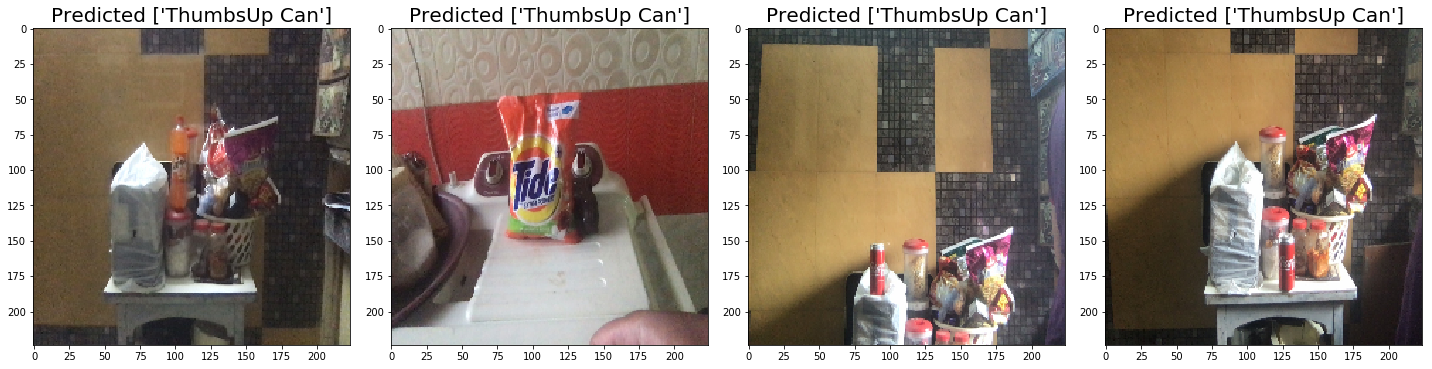

In [27]:
plt.figure(figsize=(20, 10))
for i, incorrect in enumerate(incorrect):
    plt.subplot(1,4,i+1)
    plt.imshow(valid[incorrect].reshape(224,224,3), cmap='gray', interpolation='none')
    plt.title("Predicted {}".format(prediction[incorrect]),fontsize=20)
    plt.tight_layout()

In [40]:
correct = np.where(class_pred ==valid_label)[1]
print ("Found %d incorrect labels" % len(correct))

Found 149 incorrect labels


In [3]:
#for i, correct in enumerate(correct):
#    plt.figure(figsize=(4, 4))
#    plt.imshow(valid[correct].reshape(224,224,3), cmap='gray', interpolation='none')
#    plt.title("Predicted {}".format(prediction[correct]))
#    plt.show()

In [334]:
for i,incorrect in enumerate(incorrect):
    label = "".join(prediction[i])
    img = cv2.putText(valid[incorrect], " {}".format(label), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0,0), 2)
    img = img[:,:,::-1]
    img = cv2.resize(img,(1024,1024))
    cv2.imwrite("Classification/Incorrect/"+ str(i) + '.jpg', img)

In [338]:
for i,correct in enumerate(correct):
    label = "".join(prediction[i])
    img = cv2.putText(valid[correct], " {}".format(label), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0,0), 2)
    img = img[:,:,::-1]
    img = cv2.resize(img,(1024,1024))
    cv2.imwrite("Classification/Correct/"+ str(i) + '.jpg', img)

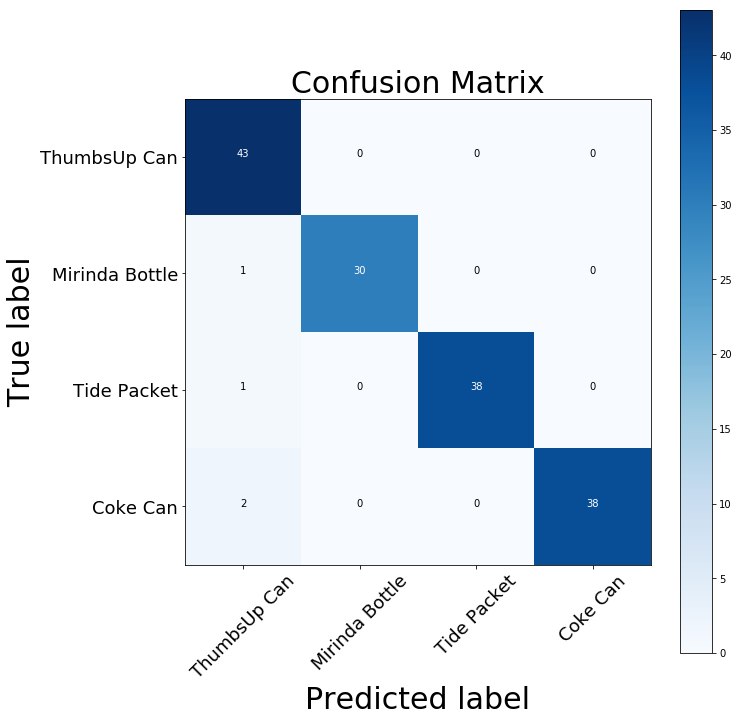

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',fontsize=30)
    plt.xlabel('Predicted label',fontsize=30)
    plt.tight_layout()
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
class_names = ['ThumbsUp Can','Mirinda Bottle','Tide Packet','Coke Can']

validation_labels = np.reshape(valid_label,(-1))
# Compute confusion matrix
cnf_matrix = confusion_matrix(validation_labels, class_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names)
plt.title('Confusion Matrix',fontsize=30)
plt.show()

In [51]:
print(classification_report(validation_labels, class_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96        43
           1       1.00      0.97      0.98        31
           2       1.00      0.97      0.99        39
           3       1.00      0.95      0.97        40

   micro avg       0.97      0.97      0.97       153
   macro avg       0.98      0.97      0.98       153
weighted avg       0.98      0.97      0.97       153

